/srv/conda/envs/notebook/lib/python3.10/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


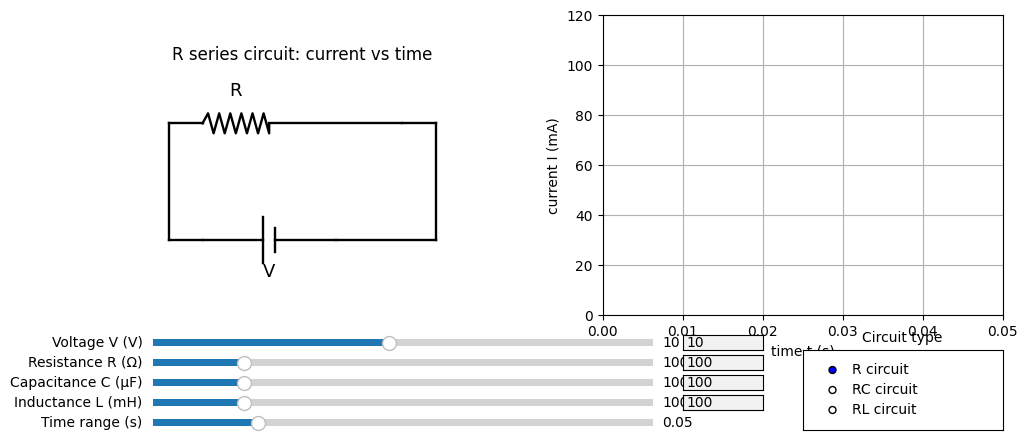

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider, RadioButtons, TextBox

# ---------------------------------------------------------------------
# 1. Simulation basic settings
# ---------------------------------------------------------------------
FPS = 30
DURATION_SEC = 4.0
TOTAL_FRAMES = int(FPS * DURATION_SEC)

V_init = 10.0
R_init = 100.0
C_init_uF = 100.0
L_init_mH = 100.0
T_sim_max = 0.05

current_circuit_type = "R"  # "R", "RC", "RL"

t_sim = np.linspace(0, T_sim_max, TOTAL_FRAMES)
i_sim = np.zeros_like(t_sim)


def calc_current(t_arr, v, r, c_uf, l_mh, circuit_type):
    """Transient current of R / RC / RL series circuit"""
    c = c_uf * 1e-6
    l = l_mh * 1e-3
    i_data = np.zeros_like(t_arr)

    if r <= 0:
        r = 1e-9

    if circuit_type == "R":
        i_data = np.full_like(t_arr, v / r)
    elif circuit_type == "RC":
        if c > 0:
            tau = r * c
            i_data = (v / r) * np.exp(-t_arr / tau)
    elif circuit_type == "RL":
        if l > 0:
            tau = l / r
            i_data = (v / r) * (1 - np.exp(-t_arr / tau))

    return i_data


# ---------------------------------------------------------------------
# 2. Figure and axes
# ---------------------------------------------------------------------
fig = plt.figure(figsize=(10, 5))
ax_circuit = fig.add_axes([0.05, 0.30, 0.40, 0.60])  # circuit diagram
ax_graph   = fig.add_axes([0.55, 0.30, 0.40, 0.60])  # I–t graph

current_dots = None  # moving current dots

# ---------------------------------------------------------------------
# 3. Element drawing functions
# ---------------------------------------------------------------------
def draw_resistor(ax, x1, x2, y, amp=0.3, segments=6, lw=1.5):
    xs, ys = [], []
    dx = (x2 - x1) / (segments * 2)
    x = x1
    xs.append(x); ys.append(y)
    direction = 1
    for _ in range(segments * 2):
        x += dx
        xs.append(x)
        ys.append(y + amp * direction)
        direction *= -1
    xs.append(x2); ys.append(y)
    ax.plot(xs, ys, "k-", lw=lw)


def draw_capacitor(ax, x_left, x_right, y, plate_gap=0.3, height=1.2, lw=1.7):
    x_c = 0.5 * (x_left + x_right)
    ax.plot([x_left, x_c - plate_gap / 2], [y, y], "k-", lw=lw)
    ax.plot([x_c + plate_gap / 2, x_right], [y, y], "k-", lw=lw)
    y1, y2 = y - height / 2, y + height / 2
    ax.plot([x_c - plate_gap / 2, x_c - plate_gap / 2], [y1, y2], "k-", lw=lw)
    ax.plot([x_c + plate_gap / 2, x_c + plate_gap / 2], [y1, y2], "k-", lw=lw)


def draw_inductor(ax, x_left, x_right, y, loops=4, lw=1.7):
    lead = 0.4
    ax.plot([x_left, x_left + lead], [y, y], "k-", lw=lw)
    ax.plot([x_right - lead, x_right], [y, y], "k-", lw=lw)

    usable = (x_right - x_left) - 2 * lead
    spacing = usable / loops
    radius = spacing / 2.0
    start = x_left + lead

    for i in range(loops):
        theta = np.linspace(np.pi, 0, 40)
        x_center = start + i * spacing + radius
        x = x_center + radius * np.cos(theta)
        y_vals = y + radius * np.sin(theta)
        ax.plot(x, y_vals, "k-", lw=lw)


def draw_voltage_source(ax, x_left, x_right, y, plate_gap=0.35,
                        long_h=1.5, short_h=0.8, lw=1.7):
    x_c = 0.5 * (x_left + x_right)
    x_long = x_c - plate_gap / 2
    x_short = x_c + plate_gap / 2
    ax.plot([x_left, x_long], [y, y], "k-", lw=lw)
    ax.plot([x_short, x_right], [y, y], "k-", lw=lw)
    ax.plot([x_long, x_long], [y - long_h / 2, y + long_h / 2], "k-", lw=lw)
    ax.plot([x_short, x_short], [y - short_h / 2, y + short_h / 2], "k-", lw=lw)
    ax.text(x_c, y - long_h / 2 - 0.4, "V", ha="center", fontsize=13)


# ---------------------------------------------------------------------
# 4. Path of current dots (single clockwise loop)
# ---------------------------------------------------------------------
xL, xR = 2.0, 10.0
y_top, y_bot = 5.0, 1.5

# clockwise: bottom-left → top-left → top-right → bottom-right → bottom-left
path_points = np.array([
    [xL, y_bot],
    [xL, y_top],
    [xR, y_top],
    [xR, y_bot],
    [xL, y_bot],
])

seg_vecs = np.diff(path_points, axis=0)
seg_lens = np.linalg.norm(seg_vecs, axis=1)
seg_cum = np.concatenate([[0], np.cumsum(seg_lens)])
total_len = seg_cum[-1]
N_DOTS = 16


def point_on_path_no_wrap(s):
    """Return point on path for 0 <= s <= total_len (no wrap)."""
    if s <= 0:
        return path_points[0]
    if s >= total_len:
        return path_points[-1]
    idx = np.searchsorted(seg_cum, s, side="right") - 1
    ds = s - seg_cum[idx]
    L = seg_lens[idx]
    if L == 0:
        return path_points[idx]
    t = ds / L
    return path_points[idx] + t * seg_vecs[idx]


# ---------------------------------------------------------------------
# 5. Draw circuit and init current dots
# ---------------------------------------------------------------------
def draw_circuit(ax, circuit_type, V, R, extra_val):
    global current_dots

    ax.clear()
    ax.set_aspect("equal")
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 7.5)
    ax.axis("off")
    lw = 1.7

    # outer wires
    ax.plot([xL, xL], [y_bot, y_top], "k-", lw=lw)
    ax.plot([xR, xR], [y_bot, y_top], "k-", lw=lw)
    ax.plot([xL, 3.0], [y_top, y_top], "k-", lw=lw)
    ax.plot([9.0, xR], [y_top, y_top], "k-", lw=lw)
    ax.plot([xL, 3.0], [y_bot, y_bot], "k-", lw=lw)
    ax.plot([7.0, xR], [y_bot, y_bot], "k-", lw=lw)

    # voltage source
    draw_voltage_source(ax, 3.0, 7.0, y_bot,
                        plate_gap=0.35, long_h=1.4, short_h=0.7, lw=lw)

    # positions of components on top branch
    xR1, xR2 = 3.0, 5.0
    xX1, xX2 = 6.5, 8.5

    # resistor
    draw_resistor(ax, xR1, xR2, y_top, amp=0.3, segments=6, lw=lw)
    ax.text((xR1 + xR2) / 2, y_top + 0.7, "R",
            ha="center", va="bottom", fontsize=13)

    if circuit_type == "RC":
        ax.plot([xR2, xX1], [y_top, y_top], "k-", lw=lw)
        draw_capacitor(ax, xX1, xX2, y_top, plate_gap=0.35, height=1.2, lw=lw)
        ax.plot([xX2, 9.0], [y_top, y_top], "k-", lw=lw)
        ax.text((xX1 + xX2) / 2, y_top - 0.8, "C",
                ha="center", va="top", fontsize=13)
        title = "RC series circuit: current vs time"

    elif circuit_type == "RL":
        ax.plot([xR2, xX1], [y_top, y_top], "k-", lw=lw)
        draw_inductor(ax, xX1, xX2, y_top, loops=4, lw=lw)
        ax.plot([xX2, 9.0], [y_top, y_top], "k-", lw=lw)
        ax.text((xX1 + xX2) / 2, y_top - 0.8, "L",
                ha="center", va="top", fontsize=13)
        title = "RL series circuit: current vs time"

    else:
        ax.plot([xR2, 9.0], [y_top, y_top], "k-", lw=lw)
        title = "R series circuit: current vs time"

    ax.text(6.0, 6.9, title, ha="center", fontsize=12)

    # current dots
    current_dots = ax.scatter([], [], s=25, c="red", alpha=0.0)
    return current_dots


current_dots = draw_circuit(ax_circuit, current_circuit_type, V_init, R_init, C_init_uF)

# ---------------------------------------------------------------------
# 6. Graph area
# ---------------------------------------------------------------------
graph_line, = ax_graph.plot([], [], "b-", lw=2)
ax_graph.set_xlim(0, T_sim_max)
ax_graph.set_ylim(0, (V_init / R_init) * 1.2 * 1000)
ax_graph.set_xlabel("time t (s)")
ax_graph.set_ylabel("current I (mA)")
ax_graph.grid(True)

time_text = ax_graph.text(
    0.70, 0.85, "",
    transform=ax_graph.transAxes,
    bbox=dict(facecolor="white", alpha=0.7),
    fontsize=10,
)

# ---------------------------------------------------------------------
# 7. Sliders, text boxes, radio buttons
# ---------------------------------------------------------------------
ax_V  = fig.add_axes([0.10, 0.23, 0.50, 0.03])
ax_Rs = fig.add_axes([0.10, 0.19, 0.50, 0.03])
ax_Cs = fig.add_axes([0.10, 0.15, 0.50, 0.03])
ax_Ls = fig.add_axes([0.10, 0.11, 0.50, 0.03])
ax_T  = fig.add_axes([0.10, 0.07, 0.50, 0.03])

ax_type = fig.add_axes([0.75, 0.07, 0.20, 0.16])

ax_V_box  = fig.add_axes([0.63, 0.23, 0.08, 0.03])
ax_R_box  = fig.add_axes([0.63, 0.19, 0.08, 0.03])
ax_C_box  = fig.add_axes([0.63, 0.15, 0.08, 0.03])
ax_L_box  = fig.add_axes([0.63, 0.11, 0.08, 0.03])

s_V  = Slider(ax_V,  "Voltage V (V)",      1, 20,  valinit=V_init,    valfmt="%g")
s_R  = Slider(ax_Rs, "Resistance R (Ω)",   10, 500, valinit=R_init,   valfmt="%g")
s_C  = Slider(ax_Cs, "Capacitance C (μF)", 10, 500, valinit=C_init_uF, valfmt="%g")
s_L  = Slider(ax_Ls, "Inductance L (mH)",  10, 500, valinit=L_init_mH, valfmt="%g")
s_T  = Slider(ax_T,  "Time range (s)", 0.01, 0.2, valinit=T_sim_max,  valfmt="%g")

radio_type = RadioButtons(ax_type, ("R circuit", "RC circuit", "RL circuit"))
ax_type.set_title("Circuit type", fontsize=10)

text_V = TextBox(ax_V_box, " ", initial=str(V_init))
text_R = TextBox(ax_R_box, " ", initial=str(R_init))
text_C = TextBox(ax_C_box, " ", initial=str(C_init_uF))
text_L = TextBox(ax_L_box, " ", initial=str(L_init_mH))

updating_textboxes = False

# TextBox → Slider callbacks
def submit_V(text):
    global updating_textboxes
    if updating_textboxes:
        return
    try:
        val = float(text)
    except ValueError:
        return
    val = np.clip(val, s_V.valmin, s_V.valmax)
    s_V.set_val(val)

def submit_R(text):
    global updating_textboxes
    if updating_textboxes:
        return
    try:
        val = float(text)
    except ValueError:
        return
    val = np.clip(val, s_R.valmin, s_R.valmax)
    s_R.set_val(val)

def submit_C(text):
    global updating_textboxes
    if updating_textboxes:
        return
    try:
        val = float(text)
    except ValueError:
        return
    val = np.clip(val, s_C.valmin, s_C.valmax)
    s_C.set_val(val)

def submit_L(text):
    global updating_textboxes
    if updating_textboxes:
        return
    try:
        val = float(text)
    except ValueError:
        return
    val = np.clip(val, s_L.valmin, s_L.valmax)
    s_L.set_val(val)

text_V.on_submit(submit_V)
text_R.on_submit(submit_R)
text_C.on_submit(submit_C)
text_L.on_submit(submit_L)

# ---------------------------------------------------------------------
# 8. Animation functions
# ---------------------------------------------------------------------
def init_anim():
    graph_line.set_data([], [])
    time_text.set_text("")
    current_dots.set_offsets(np.empty((0, 2)))
    current_dots.set_alpha(0.0)
    return graph_line, time_text, current_dots


def update_anim(frame):
    """frame: 0 .. TOTAL_FRAMES-1, current flows in one direction only."""
    if len(t_sim) == 0:
        return graph_line, time_text, current_dots

    idx = min(frame, len(t_sim) - 1)
    current_t = t_sim[:idx + 1]
    current_i = i_sim[:idx + 1] * 1000.0  # mA

    graph_line.set_data(current_t, current_i)
    time_text.set_text(f"t = {t_sim[idx]:.4f} s")

    I_now = current_i[-1] if len(current_i) > 0 else 0.0
    I_max = (s_V.val / s_R.val) * 1000.0 if s_R.val > 0 else 1.0
    norm = 0.0 if I_max <= 0 else np.clip(abs(I_now) / I_max, 0.0, 1.0)

    base_speed = total_len / TOTAL_FRAMES
    pts = []
    for k in range(N_DOTS):
        s0 = -k * total_len / N_DOTS
        s = s0 + base_speed * frame
        if 0 <= s <= total_len:
            x, y = point_on_path_no_wrap(s)
            pts.append([x, y])

    if pts:
        pts_arr = np.array(pts)
        current_dots.set_offsets(pts_arr)
        current_dots.set_alpha(0.2 + 0.8 * norm)
    else:
        current_dots.set_offsets(np.empty((0, 2)))
        current_dots.set_alpha(0.0)

    return graph_line, time_text, current_dots


# ---------------------------------------------------------------------
# 9. Slider / radio callbacks
# ---------------------------------------------------------------------
def on_change(val):
    global t_sim, i_sim, current_circuit_type, current_dots, updating_textboxes

    v = s_V.val
    r = s_R.val
    c = s_C.val
    l = s_L.val
    tmax = s_T.val
    label = radio_type.value_selected

    if "RC" in label:
        current_circuit_type = "RC"
        extra_val = c
    elif "RL" in label:
        current_circuit_type = "RL"
        extra_val = l
    else:
        current_circuit_type = "R"
        extra_val = 0.0

    t_sim[:] = np.linspace(0, tmax, TOTAL_FRAMES)
    i_sim[:] = calc_current(t_sim, v, r, c, l, current_circuit_type)

    ax_graph.set_xlim(0, tmax)
    max_i_ma = (v / r) * 1000.0 if r > 0 else 1.0
    ax_graph.set_ylim(0, max_i_ma * 1.2 if max_i_ma > 0 else 1.0)

    current_dots = draw_circuit(ax_circuit, current_circuit_type, v, r, extra_val)
    graph_line.set_data([], [])
    time_text.set_text("")

    # sync text boxes from sliders
    updating_textboxes = True
    text_V.set_val(f"{v:g}")
    text_R.set_val(f"{r:g}")
    text_C.set_val(f"{c:g}")
    text_L.set_val(f"{l:g}")
    updating_textboxes = False

    fig.canvas.draw_idle()


s_V.on_changed(on_change)
s_R.on_changed(on_change)
s_C.on_changed(on_change)
s_L.on_changed(on_change)
s_T.on_changed(on_change)
radio_type.on_clicked(on_change)

on_change(None)

# ---------------------------------------------------------------------
# 10. Run animation (save static image on non-interactive backend)
# ---------------------------------------------------------------------
backend = plt.get_backend().lower()
anim = None

if "agg" in backend:
    # draw last frame and save
    update_anim(TOTAL_FRAMES - 1)
    fig.savefig("circuit_simulation_animation.png", dpi=150, bbox_inches="tight")
    print("saved: circuit_simulation_animation.png")
else:
    anim = FuncAnimation(
        fig,
        update_anim,
        frames=TOTAL_FRAMES,
        init_func=init_anim,
        interval=1000 / FPS,
        blit=False,
    )
    plt.show()